# Installations

In [1]:
!pip install textblob

# Commit to GitHub

In [2]:
!pwd                # shows your current folder
!git status         # check uncommitted changes
!git add .
!git commit -m "EDA Explanations and Analysis"
!git push origin main

'pwd' is not recognized as an internal or external command,
operable program or batch file.


On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


[main 8303826] EDA Explanations and Analysis
 1 file changed, 25 insertions(+), 104 deletions(-)


To https://github.com/Starlight0901/Reddit_SriLanka_Social_Insight.git
   6b38493..8303826  main -> main


# Imports

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
from nltk import ngrams
from textblob import TextBlob
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tharu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Exploratory Data Analysis

In [4]:
# Load dataset
df_posts = pd.read_csv("Final_Posts_Data.csv")
df_posts.head()

C:\Users\tharu\AppData\Local\Temp\ipykernel_14948\3966237626.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_posts = pd.read_csv("Final_Posts_Data.csv")


,type,source,keyword,id,created_utc,author,subreddit,content,score,num_comments,parent_post
0,post,new,NaN,1otaemb,1.762771e+09,Cookiehere6969,srilanka,Is this a Scam or good investment? Haritha Lan...,2.0,1.0,NaN
1,post,new,NaN,1otaam5,1.762770e+09,oshan789,srilanka,Villa units for sale in Unawatuna Sri Lanka ! ...,3.0,0.0,NaN
2,post,new,NaN,1ot9w1v,1.762769e+09,mgssjjsks,srilanka,Whats your hot take on Sri Lanka as the title ...,3.0,8.0,NaN
3,post,new,NaN,1ot9kwe,1.762768e+09,Critical_Rise_exe,srilanka,Is the rs.11 deals real in Daraz?,1.0,3.0,NaN
4,post,new,NaN,1ot9h2f,1.762767e+09,No-Leave8971,srilanka,Need advice from the experts 🙏 [](https://www....,2.0,0.0,NaN


In [5]:
# Dataset overview
print("Dataset shape:", df_posts.shape)

Dataset shape: (70861, 11)


In [6]:
print("\nColumns:", df_posts.columns)


Columns: Index(['type', 'source', 'keyword', 'id', 'created_utc', 'author', 'subreddit',
       'content', 'score', 'num_comments', 'parent_post'],
      dtype='object')


In [7]:
print("\nData types:\n", df_posts.dtypes)


Data types:
 type             object
source           object
keyword          object
id               object
created_utc     float64
author           object
subreddit        object
content          object
score           float64
num_comments    float64
parent_post      object
dtype: object


In [8]:
print("\nMissing values per column:\n", df_posts.isnull().sum())


Missing values per column:
 type                0
source              0
keyword         53250
id                  0
created_utc         0
author           2981
subreddit           0
content             1
score               8
num_comments    52021
parent_post     18848
dtype: int64


In [9]:
# Number of posts
num_posts = len(df_posts)
print("Total number of posts:", num_posts)

# Number of unique authors
num_authors = df_posts['author'].nunique()
print("Number of unique authors:", num_authors)

# Number of subreddits (should be 1 for r/srilanka)
num_subreddits = df_posts['subreddit'].nunique()
print("Subreddits in dataset:", df_posts['subreddit'].unique())


Total number of posts: 70861
Number of unique authors: 15269
Subreddits in dataset: ['srilanka']


In [10]:
# Compute number of words in each post
df_posts['word_count'] = df_posts['content'].apply(lambda x: len(str(x).split()))

# Summary statistics
print(df_posts[['word_count']].describe()) 

         word_count
count  70861.000000
mean      63.012828
std       97.379429
min        1.000000
25%       15.000000
50%       33.000000
75%       74.000000
max     4276.000000


Summary of Word Count Statistics:
Mean ≈ 63 words, Median = 33 words → long texts are inflating the average.

Distribution:
50% of texts fall between 15–74 words (IQR).
75% have ≤ 74 words.

Dispersion & Outliers:
High SD (~97) → word counts vary widely.
Max = 4,276 words → extreme outlier compared to the 75th percentile.

- Most texts are short and concise.
- Half of the dataset contains texts with 33 words or less.
- A small number of extremely long documents distort the mean and SD.

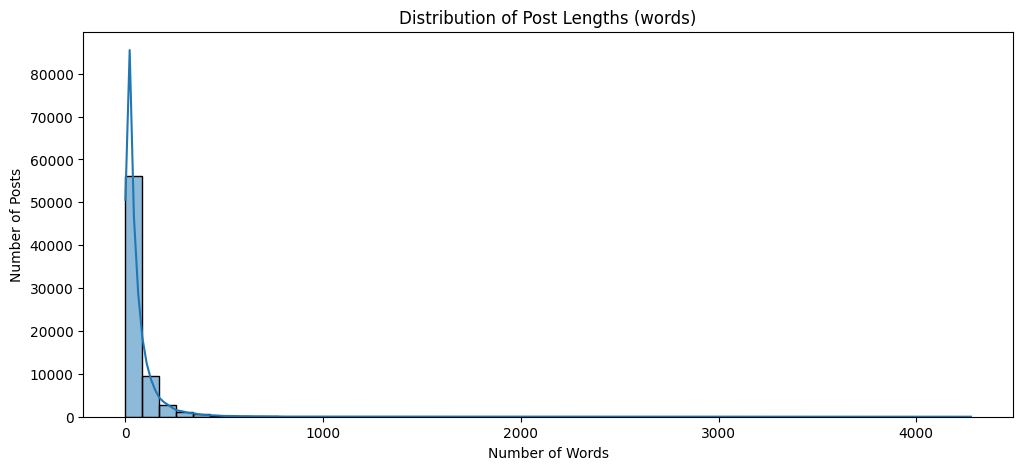

In [11]:
plt.figure(figsize=(12,5))
sns.histplot(df_posts['word_count'], bins=50, kde=True)
plt.title("Distribution of Post Lengths (words)")
plt.xlabel("Number of Words")
plt.ylabel("Number of Posts")
plt.show()

Distribution Shape
- Strong right/positive skew: A large peak at very short word counts with a long tail toward very long posts.
- KDE curve confirms the skew and highlights the heavy concentration of short posts.

Key Observations
- Most posts are very short: The tallest bar (over 50,000 posts) appears at the lowest word-count range.
- Sharp drop-off: Post frequency declines rapidly as word count increases.
- Long posts exist but rare: The long right tail shows a small number of extremely long posts (up to ~4,000 words).

Connection to Statistical Measures
- Mean > Median: Outliers (very long posts) pull the mean up, while the median stays low—matching the histogram shape.
- High standard deviation: The long tail visualizes the wide variability in text lengths.
- Quartiles: 75% of posts are under 74 words; the histogram shows the bulk concentrated in the left-most bins.
- Outliers: Extremely long posts appear far to the right, consistent with the maximum value observed.

Insights About r/srilanka Posting Behavior
- Dominance of short-form content: Quick posts like memes, headlines, questions, and brief comments are most common.
- Small niche for long-form posts: Detailed stories, travel guides, personal experiences, or political analyses exist but are rare.
- Typical online community pattern: High volume of brief content with occasional high-effort, long contributions.

In [12]:
from collections import Counter
import re

# Combine all text
all_text = " ".join(df_posts['content'].dropna()).lower()

# Basic tokenization: split by non-alphanumeric
tokens = re.findall(r'\b\w+\b', all_text)

# Count frequency
word_freq = Counter(tokens)
most_common_words = word_freq.most_common(20)
print("Most common words:\n", most_common_words)


Most common words:
 [('the', 165507), ('to', 130421), ('and', 109056), ('a', 106003), ('i', 105299), ('in', 73763), ('of', 67569), ('is', 61432), ('it', 58816), ('for', 55983), ('you', 55112), ('that', 44175), ('this', 36207), ('s', 35179), ('are', 34742), ('t', 31852), ('have', 31108), ('but', 29853), ('they', 28546), ('on', 28230)]


In [13]:
# Remove stopwords
tokens_no_stop = [word for word in tokens if word not in stop_words]

# Count frequency
word_freq = Counter(tokens_no_stop)
most_common_words = word_freq.most_common(20)
print("Most common words (stopwords removed):\n", most_common_words)


Most common words (stopwords removed):
 [('sri', 22420), ('like', 18928), ('people', 16446), ('lanka', 16388), ('get', 14498), ('would', 12489), ('know', 10874), ('good', 10719), ('one', 10516), ('even', 10426), ('also', 10060), ('time', 9488), ('think', 8014), ('go', 7755), ('country', 7553), ('need', 7374), ('want', 6771), ('much', 6476), ('https', 6314), ('really', 6196)]


*Common Words — Summary*

1. National Identity & Geography
- High-frequency words: sri, lanka, country
- Shows strong focus on Sri Lankan identity, national issues, and country-specific discussions.
- Slight difference between "sri" and "lanka" likely due to varied phrase usage (e.g., “Sri Lankan”).

2. Conversational & Subjective Expression
- Key words: like, would, know, even, think, really
    * Reflects:
      - Informal, conversational tone.
      - Opinion-sharing and personal reflection.
      - Use of sort of hypotheticals, examples, and nuanced discussion.
      - Engagement in debates, questions, and explanations.

3. People & Community Focus
- Key word: people
  - Indicates discussions centered on:
    - Citizens of Sri Lanka
    - Social behavior, culture, norms
    - Public opinion and community experiences

4. Evaluation & Sentiment
- Key word: good
    - Shows that the subreddit frequently evaluates and judges:
        -  Places, services, recommendations
        -  Quality of experiences
        -  Governance, public issues, etc.

*Overall Interpretation*
- A Hub for National Dialogue
    -  Discussions revolve heavily around Sri Lanka, its people, and national issues.
- Highly Conversational & Opinion-Driven**
    -  Language shows a casual tone and personal engagement rather than formal information delivery.
- Problem-Solving & Aspirational
    -  Frequent references to needs and actions suggest users discuss challenges, solutions, and improvements.

C:\Users\tharu\AppData\Local\Temp\ipykernel_14948\1289054692.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


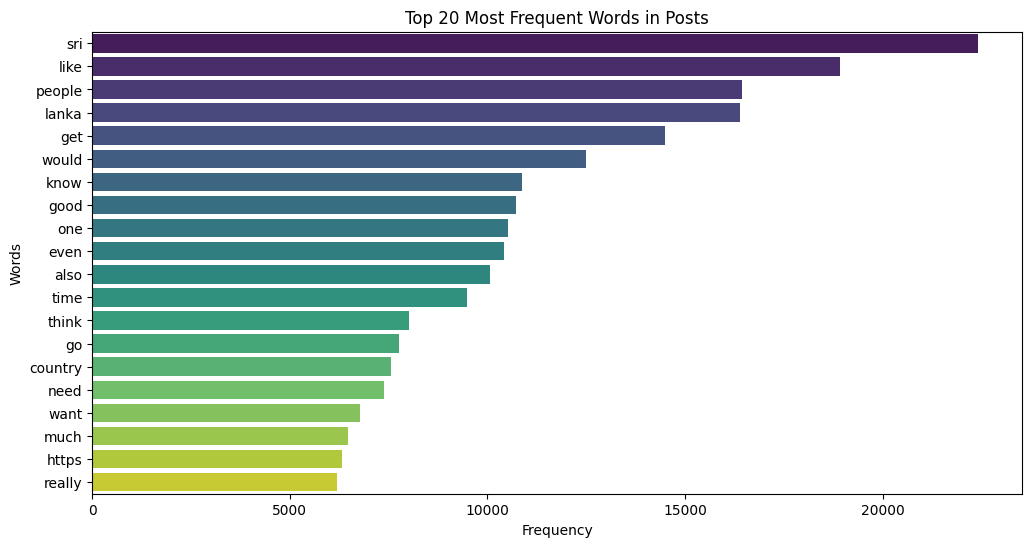

In [14]:
words, counts = zip(*most_common_words)
plt.figure(figsize=(12,6))
sns.barplot(x=list(counts), y=list(words), palette="viridis")
plt.title("Top 20 Most Frequent Words in Posts")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

The chart of the top 20 most frequent words shows that the r/srilanka subreddit is strongly centered on Sri Lanka and its people. The vocabulary highlights a highly conversational and opinion-driven community, where users frequently express personal thoughts, ask questions, and discuss everyday experiences. Many of the top words relate to actions, needs, and practical concerns, reflecting a focus on problem-solving, advice, and real-life situations. The presence of evaluative terms shows that users often assess or recommend things. Additionally, the high occurrence of “https” confirms that link-sharing is a major part of how information flows in the subreddit.

Overall, the language profile reveals a lively, discussion-oriented community that combines personal viewpoints, practical inquiries, and external content to engage with national and social topics.

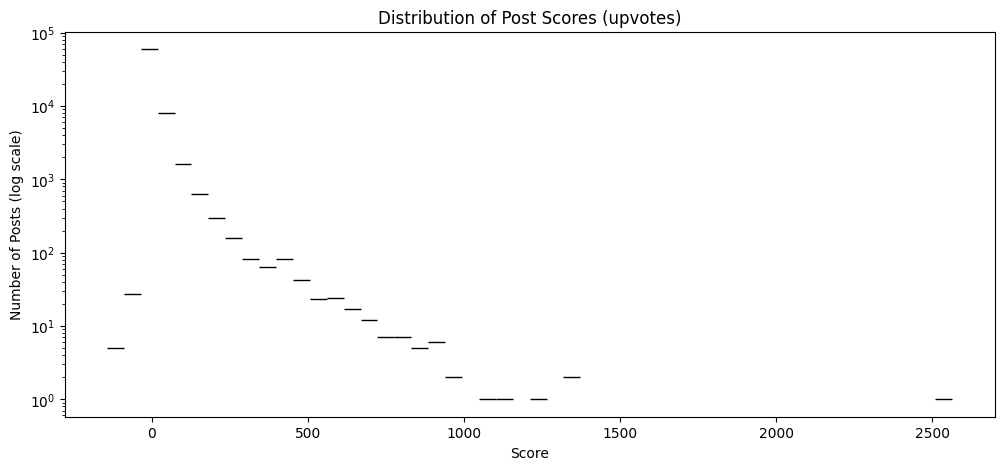

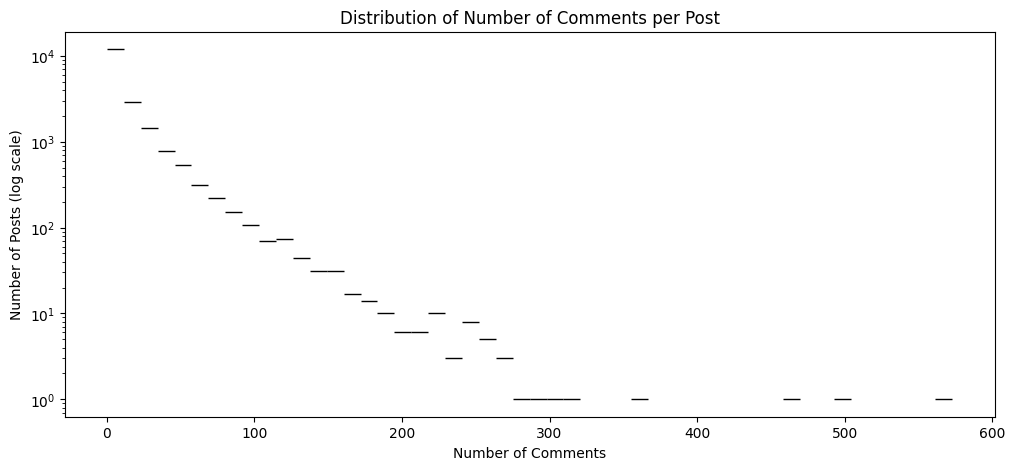

In [15]:
# Score (upvotes)
plt.figure(figsize=(12,5))
sns.histplot(df_posts['score'], bins=50, log_scale=(False, True))
plt.title("Distribution of Post Scores (upvotes)")
plt.xlabel("Score")
plt.ylabel("Number of Posts (log scale)")
plt.show()

# Number of comments
plt.figure(figsize=(12,5))
sns.histplot(df_posts['num_comments'], bins=50, log_scale=(False, True), color='green')
plt.title("Distribution of Number of Comments per Post")
plt.xlabel("Number of Comments")
plt.ylabel("Number of Posts (log scale)")
plt.show()


*Distribution of Post Scores (Upvotes)*
- The y-axis uses a log scale, meaning differences of 10× per tick.
- Most posts receive very few upvotes (0–10). This huge cluster forms the tallest part of the graph.
- As score increases, the number of posts drops sharply.
- ~100 posts reach a score around 400.
- Fewer than 10 posts reach 1000.
- One post peaks around ~2600.

* Interpretation: Upvote distribution follows a power-law — only a tiny number of posts become highly popular.

*Chart 2: Distribution of Comments*
- Most posts get very few comments, often 0–10.
- Posts with many comments are rare:
- ~1000 posts have around 50 comments.
- ~100 posts have around 150 comments.
- Only a few reach several hundred comments.

* Interpretation: Meaningful discussions happen only on a small fraction of posts.

C:\Users\tharu\AppData\Local\Temp\ipykernel_14948\293382391.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_authors.values, y=top_authors.index, palette="coolwarm")


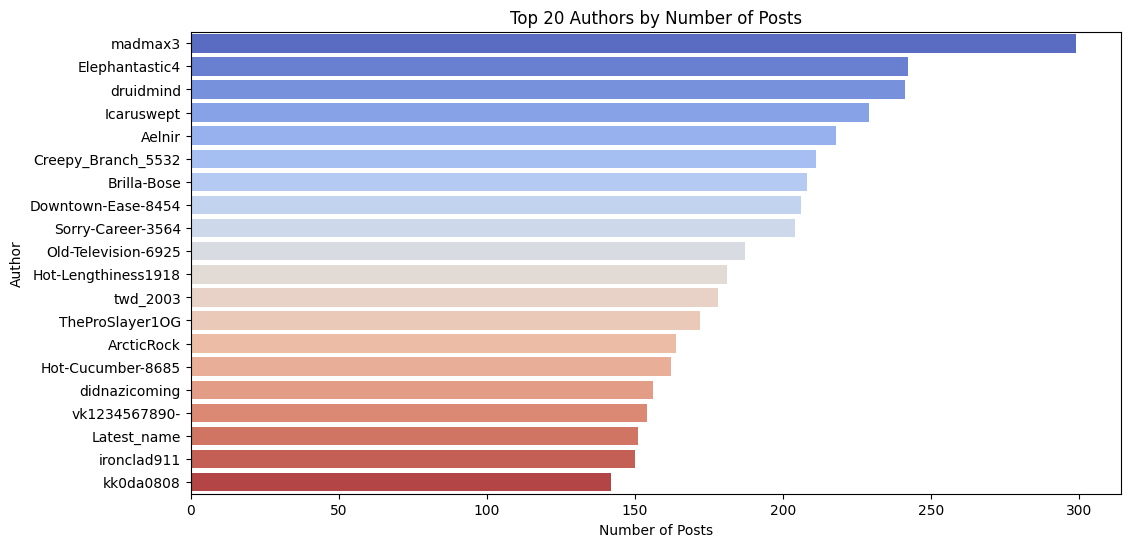

In [16]:
# Top 20 authors by number of posts
top_authors = df_posts['author'].value_counts().head(20)
plt.figure(figsize=(12,6))
sns.barplot(x=top_authors.values, y=top_authors.index, palette="coolwarm")
plt.title("Top 20 Authors by Number of Posts")
plt.xlabel("Number of Posts")
plt.ylabel("Author")
plt.show()

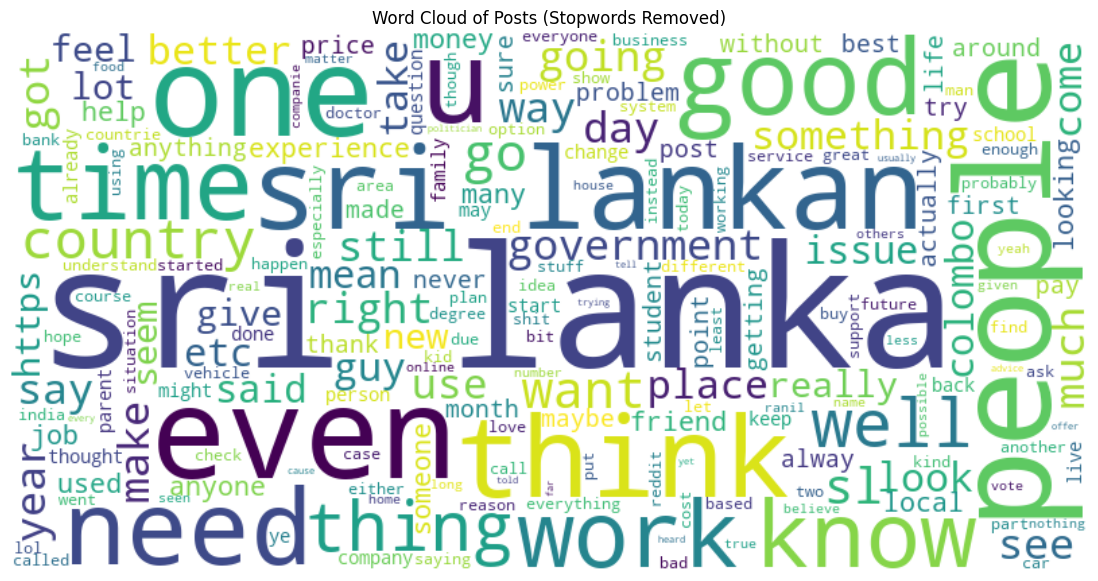

In [17]:
# Word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(tokens_no_stop))
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Posts (Stopwords Removed)")
plt.show()

The word cloud provides a better idea of the r/srilanka subreddit’s character and focus. At its core, the discussions revolve around Sri Lanka and its people, emphasizing both national identity and human-centric topics. 

Prominent words like think, know, need, and good show that the subjective thought, sharing knowledge, expressing desires, and evaluating experiences are shared. 

Medium-sized words reveal key themes such as daily life and practical concerns (e.g., job, money, school, buy), communication and opinion-sharing (e.g., say, tell, feel, question), community and relationships (e.g., friend, family, parent), and problem-solving (e.g., issue, support, help). 

Specific terms like Colombo and https highlight localized discussions and frequent sharing of external links. Overall, the word cloud illustrates a vibrant, interactive community where users engage in thoughtful discussion, seek and offer advice, and talk about both national and personal matters, making the subreddit a digital town square for Sri Lankans.

In [18]:
# Bigram / Trigram Analysis

from nltk import ngrams

def get_top_ngrams(tokens, n=2, top_k=20):
    ngram_list = list(ngrams(tokens, n))
    ngram_freq = Counter(ngram_list)
    return ngram_freq.most_common(top_k)

top_bigrams = get_top_ngrams(tokens_no_stop, n=2)
top_trigrams = get_top_ngrams(tokens_no_stop, n=3)

print("\nTop 20 Bigrams:", top_bigrams)
print("\nTop 20 Trigrams:", top_trigrams)


Top 20 Bigrams: [(('sri', 'lanka'), 15846), (('sri', 'lankan'), 4689), (('https', 'www'), 3119), (('sri', 'lankans'), 1622), (('reddit', 'com'), 887), (('thanks', 'advance'), 873), (('feel', 'like'), 847), (('social', 'media'), 834), (('would', 'like'), 824), (('www', 'reddit'), 791), (('_', '_'), 713), (('anyone', 'know'), 699), (('even', 'though'), 661), (('make', 'sure'), 622), (('would', 'love'), 613), (('long', 'term'), 601), (('let', 'know'), 579), (('https', 'preview'), 568), (('preview', 'redd'), 568), (('auto', 'webp'), 568)]

Top 20 Trigrams: [(('www', 'reddit', 'com'), 778), (('https', 'www', 'reddit'), 770), (('_', '_', '_'), 697), (('https', 'preview', 'redd'), 568), (('reddit', 'com', 'r'), 548), (('format', 'png', 'auto'), 375), (('png', 'auto', 'webp'), 375), (('com', 'r', 'srilanka'), 356), (('r', 'srilanka', 'comments'), 294), (('www', 'youtube', 'com'), 283), (('https', 'www', 'youtube'), 270), (('en', 'wikipedia', 'org'), 270), (('wikipedia', 'org', 'wiki'), 270), 

The most frequent bigrams and trigrams in the dataset reveal three major themes: strong geographic identity, heavy presence of URL metadata, and common conversational patterns. Country-related terms such as “sri lanka,” “sri lankan,” and “sri lankans” appear most frequently, showing that discussions are strongly centered on local topics. A significant portion of both bigrams and trigrams consists of URL fragments—such as “https www,” “reddit com,” “www reddit,” “https preview redd,” “www youtube com,” and “en wikipedia org” : which indicates that many posts include external links, images, videos, or previews. Beyond these technical patterns, the dataset also contains conversational and help-seeking phrases like “thanks advance,” “feel like,” “anyone know,” “would like,” “please let know,” and “would love hear,” reflecting the community’s tendency to ask for information, share opinions, or seek advice. Overall, the n-gram patterns highlight a subreddit rich in local discussion, frequent media sharing, and active conversational engagement.

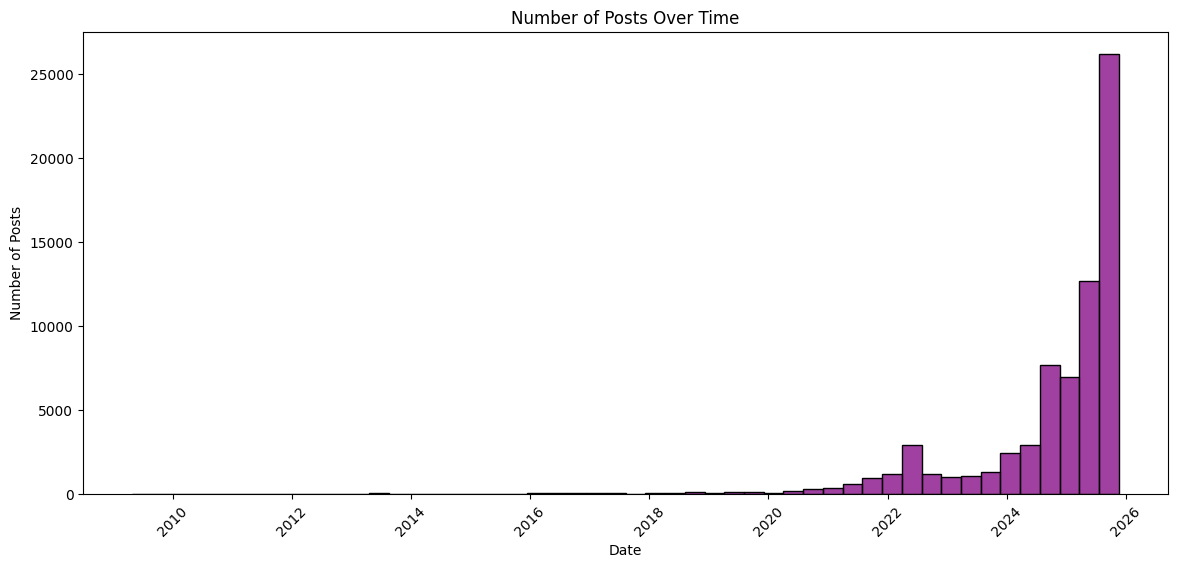

In [19]:
import matplotlib.dates as mdates
# Temporal Analysis

# Convert timestamp to datetime
df_posts['created_utc'] = pd.to_datetime(df_posts['created_utc'], unit='s')

plt.figure(figsize=(14,6))
sns.histplot(df_posts['created_utc'], bins=50, kde=False, color='purple')
plt.title("Number of Posts Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Posts")
plt.xticks(rotation=45)
plt.show() 

The "Number of Posts Over Time" histogram highlights the sudden growth of the r/srilanka subreddit. Activity was nearly nonexistent before 2018, reflecting a small or dormant community. From 2018 to 2021, posting began to pick up steadily, signaling the formation of a more consistent user base. A major surge occurred in 2022, likely driven by the Sri Lankan protests (Aragalaya), turning the subreddit into a key platform for news, discussion, and public opinion during the crisis. Activity remained high through 2023–2024, and 2025 shows an unprecedented peak, indicating sustained and growing engagement. Overall, the chart illustrates how real-world events, particularly political and economic upheavals, have directly shaped the subreddit, transforming it from a niche forum into a central hub for community interaction and national discourse.

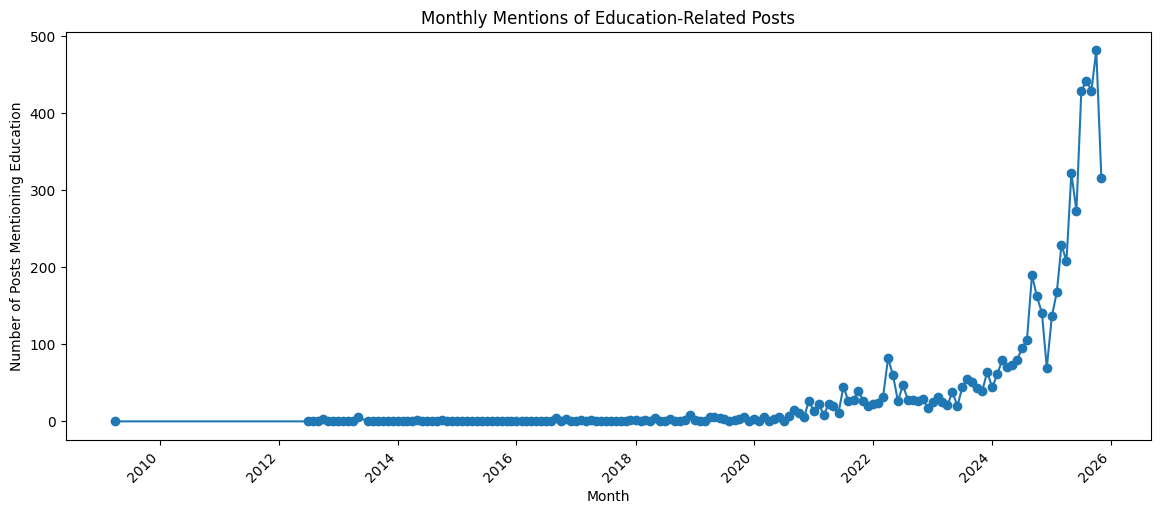

In [20]:
# Ensure created_utc is datetime
df_posts['created_utc'] = pd.to_datetime(df_posts['created_utc'], errors='coerce')

# Fix education_mention (MUST include na=False)
df_posts['education_mention'] = (
    df_posts['content']
    .astype(str)
    .str.lower()
    .str.contains('education|school|university|teacher|exam', regex=True, na=False)
)

# Fix month field
df_posts['month'] = df_posts['created_utc'].dt.to_period('M')

# Group and plot
monthly_edu = df_posts.groupby('month')['education_mention'].sum()

# Convert period index → timestamp for plotting
monthly_edu.index = monthly_edu.index.to_timestamp()

plt.figure(figsize=(14,6))
monthly_edu.plot(marker='o')
plt.title("Monthly Mentions of Education-Related Posts")
plt.xlabel("Month")
plt.ylabel("Number of Posts Mentioning Education")
plt.xticks(rotation=45)
plt.show()

Line chart shows how discussions about education on r/srilanka have evolved over time. From 2010 to around 2020, education-related posts were nearly nonexistent. Between 2020 and 2023, mentions began to appear gradually as the subreddit grew, forming a steady but minor part of discussions. From 2024 onward, the topic experienced explosive growth, with monthly mentions rising sharply and showing high volatility, likely driven by real-world events such as policy changes, exam results, university admissions, or debates about education abroad. Overall, the chart reflects both the subreddit's expansion and the increasing prominence of education as a community concern, highlighting how discussions have become event-driven and closely tied to current issues affecting Sri Lanka’s youth and education system.

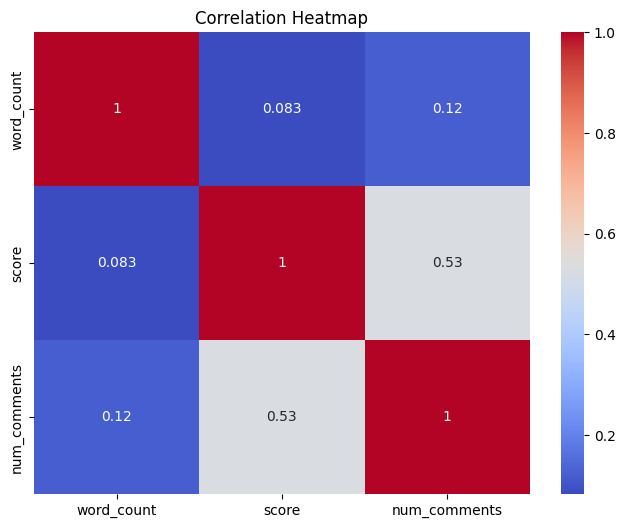

In [21]:
# Correlation Analysis
plt.figure(figsize=(8,6))
sns.heatmap(df_posts[['word_count','score','num_comments']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

The heatmap reveals three key insights about the r/srilanka subreddit data. Post length has almost no relationship with engagement—both upvotes and comments show very low correlations (~0.1) with word or character count—demonstrating that longer posts do not guarantee higher popularity. Finally, upvotes and comments are moderately correlated (0.53), highlighting the core engagement loop: popular posts attract more discussion, and active discussions drive further visibility and upvotes.


In [22]:
# Preliminary Sentiment Analysis
def get_sentiment(text):
    blob = TextBlob(str(text))
    return blob.sentiment.polarity

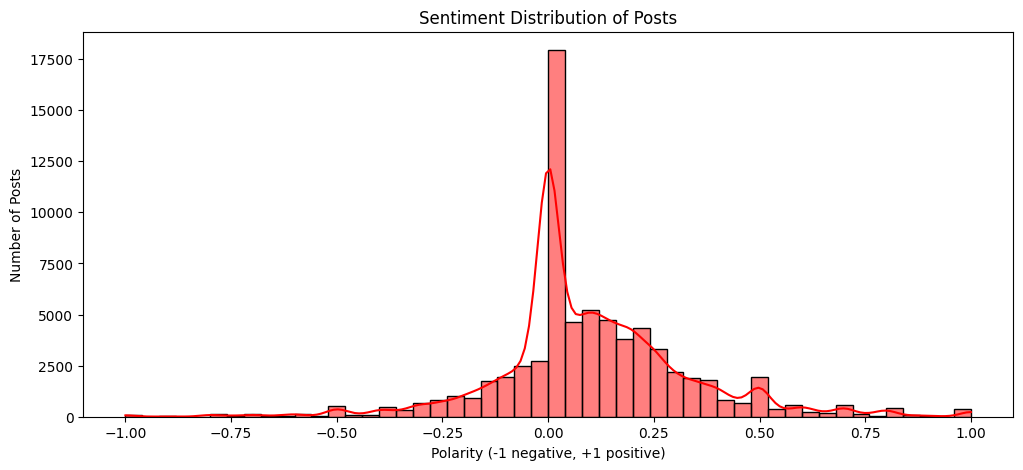

In [23]:
df_posts['sentiment'] = df_posts['content'].apply(get_sentiment)

plt.figure(figsize=(12,5))
sns.histplot(df_posts['sentiment'], bins=50, kde=True, color='red')
plt.title("Sentiment Distribution of Posts")
plt.xlabel("Polarity (-1 negative, +1 positive)")
plt.ylabel("Number of Posts")
plt.show()

The rough sentiment analysis shows that the r/srilanka subreddit is predominantly neutral-to-positive. Most posts cluster around a polarity score near 0, reflecting informational, factual, or link-based content. When posts do express emotion, they tend to be positive, highlighting constructive, helpful, or celebratory interactions. Negative posts exist but are much less frequent, forming a long tail. Overall, the distribution is multi-modal, indicating distinct clusters of neutral, positive, and occasional negative content, painting the subreddit as a generally optimistic and supportive community.

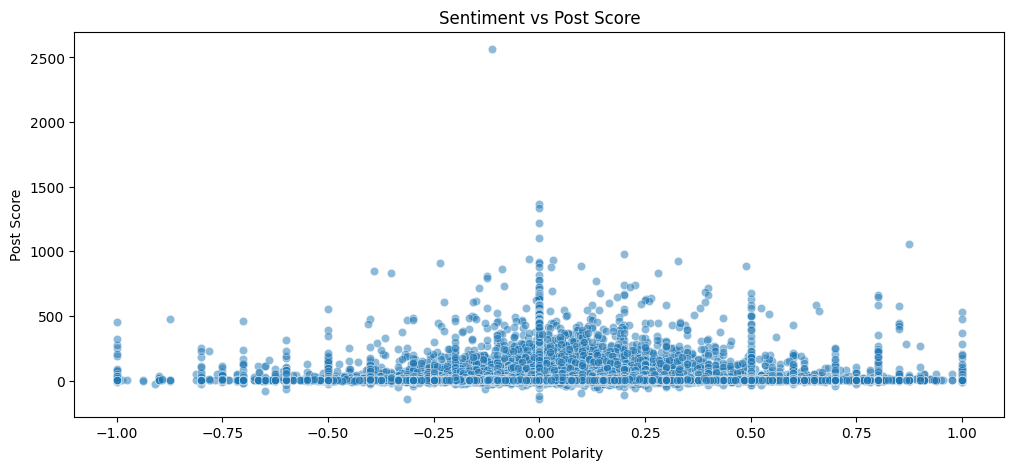

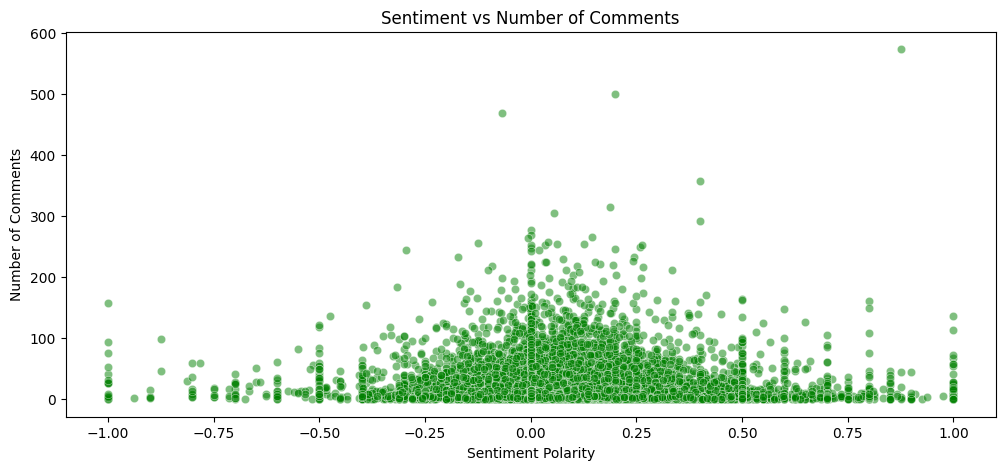

In [24]:
# Sentiment vs score/comments
plt.figure(figsize=(12,5))
sns.scatterplot(data=df_posts, x='sentiment', y='score', alpha=0.5)
plt.title("Sentiment vs Post Score")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Post Score")
plt.show()

plt.figure(figsize=(12,5))
sns.scatterplot(data=df_posts, x='sentiment', y='num_comments', alpha=0.5, color='green')
plt.title("Sentiment vs Number of Comments")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Number of Comments")
plt.show()

The first chart (Sentiment vs Post Score), plotting sentiment polarity against post scores (upvotes), shows that sentiment is not a reliable predictor of popularity. Posts with high upvotes appear across the full sentiment spectrum—from strongly positive to strongly negative—but the vast majority of posts, regardless of sentiment, receive low engagement. The most upvoted post in the dataset is nearly neutral, demonstrating that relevance, impact, and content quality are far more important than emotional tone in driving upvotes. This indicates that on r/srilanka, posts succeed based on their substance, newsworthiness, humor, or relatability rather than whether they are positive or negative.

The second chart (Sentiment vs comments Score), showing sentiment polarity against the number of comments, reveals a more nuanced relationship between emotion and discussion. Posts that are neutral to slightly negative tend to generate the most comments, forming a “debate zone” where news, problem-focused questions, or critical observations invite diverse opinions. Extremely positive or extremely negative posts can still get comments but generally spark less debate. This suggests that while sentiment has little effect on popularity, it plays a role in engagement: neutral or slightly critical content encourages discussion, whereas highly emotional content tends to attract attention without generating sustained conversation.


In [25]:
df_posts.head()

,type,source,keyword,id,created_utc,author,subreddit,content,score,num_comments,parent_post,word_count,education_mention,month,sentiment
0,post,new,NaN,1otaemb,2025-11-10 10:33:16,Cookiehere6969,srilanka,Is this a Scam or good investment? Haritha Lan...,2.0,1.0,NaN,71,False,2025-11,0.233333
1,post,new,NaN,1otaam5,2025-11-10 10:26:02,oshan789,srilanka,Villa units for sale in Unawatuna Sri Lanka ! ...,3.0,0.0,NaN,146,False,2025-11,0.235771
2,post,new,NaN,1ot9w1v,2025-11-10 10:00:29,mgssjjsks,srilanka,Whats your hot take on Sri Lanka as the title ...,3.0,8.0,NaN,15,False,2025-11,0.250000
3,post,new,NaN,1ot9kwe,2025-11-10 09:40:57,Critical_Rise_exe,srilanka,Is the rs.11 deals real in Daraz?,1.0,3.0,NaN,7,False,2025-11,0.200000
4,post,new,NaN,1ot9h2f,2025-11-10 09:33:57,No-Leave8971,srilanka,Need advice from the experts 🙏 [](https://www....,2.0,0.0,NaN,147,False,2025-11,0.185000
